# Reinforcement Learning with Mario using library [gym-super-mario-bros](https://pypi.org/project/gym-super-mario-bros/)

Study based on the course: **[Train AI to Play Super Mario Bros! || Reinforcement Learning Completely from Scratch](https://www.youtube.com/watch?v=_gmQZToTMac)**

## Libraries

- [gym-super-mario-bros](https://github.com/Kautenja/gym-super-mario-bros)
- [PyTorch](https://pytorch.org/)

## Based on the git

- [Super-Mario-Bros-RL](https://github.com/Sourish07/Super-Mario-Bros-RL/)

In [ ]:
!pip install gym-super-mario-bros==7.4.0 gym[other]==0.23.1
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torch torchvision torchaudio tensordict torchrl

In [1]:
!pip list

Package                      Version
---------------------------- ---------------
absl-py                      2.1.0
anyio                        4.3.0
argon2-cffi                  23.1.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.4.1
astunparse                   1.6.3
async-lru                    2.0.4
attrs                        23.2.0
Babel                        2.14.0
backcall                     0.2.0
beautifulsoup4               4.12.3
bleach                       6.1.0
cachetools                   5.3.2
certifi                      2024.2.2
cffi                         1.16.0
charset-normalizer           3.3.2
cloudpickle                  3.0.0
colorama                     0.4.6
comm                         0.2.1
contourpy                    1.1.1
cycler                       0.12.1
debugpy                      1.8.1
decorator                    4.4.2
defusedxml                   0.7.1
exceptiongroup               1.2.

In [1]:
import gym_super_mario_bros

from gym_super_mario_bros.actions import RIGHT_ONLY
from nes_py.wrappers import JoypadSpace

In [2]:
ENV_NAME = "SuperMarioBros-v0"
env = gym_super_mario_bros.make(ENV_NAME)
env = JoypadSpace(env, RIGHT_ONLY)

D:\Programas\miniconda3\envs\rflr_mario\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3` with the environment ID `SuperMarioBros-v3`.
  logger.warn(


In [2]:
import matplotlib.pyplot as plt

from IPython.display import clear_output

def show(img):
  plt.imshow(img)
  plt.axis("off")
  plt.show()

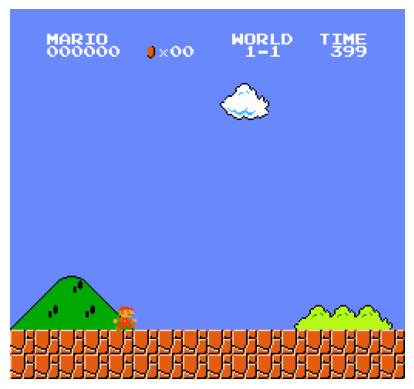

In [4]:
env.reset()

# The done is returned when the number of lifes reach 0
for step in range(30):
  action = RIGHT_ONLY.index(["right"])
  state, reward, done, info = env.step(action)
  show(state)
  clear_output(wait=True)
  if done:
    break

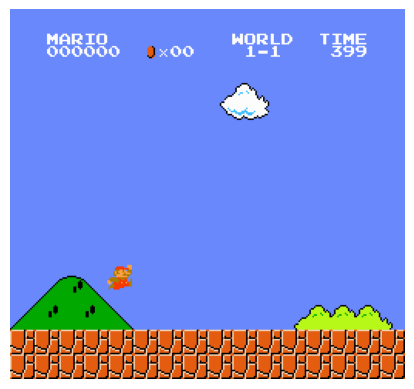

In [5]:
env.reset()

for step in range(30):
  action = env.action_space.sample()
  state, reward, done, info = env.step(action)
  show(state)
  clear_output(wait=True)

  if done:
    break
env.close()

In [3]:
import numpy as np

from gym import Wrapper
from gym.wrappers import GrayScaleObservation, ResizeObservation, FrameStack


class SkipFrame(Wrapper):

  def __init__(self, env, skip):
    super().__init__(env)
    self.skip = skip

  def step(self, action):
    total_reward = 0.0
    done = False
    for _ in range(self.skip):
      next_state, reward, done, info = self.env.step(action)
      total_reward += reward
      if done:
        break

    return next_state, reward, done, info

## Skip Frames

Skip 4 frames so we can train faster, and because, the diffence between 1 frame and the other, don't gain much information, so, in this case, skipping 4 frames, is good enough to train the agent

In [4]:
def apply_wrappers(env):
  env = SkipFrame(env, skip=4)
  env = ResizeObservation(env, shape=84)
  env = GrayScaleObservation(env)
  env = FrameStack(env, num_stack=4, lz4_compress=True)
  return env

In [5]:
import torch

from torch import nn


class AgentNN(nn.Module):

  def __init__(self, input_shape, n_actions, freeze=False):
    super().__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=4, stride=2),
        nn.ReLU(),
        nn.Conv2d(64, 64, kernel_size=3, stride=1),
        nn.ReLU()
    )

    conv_out_size = self._get_conv_out(input_shape)
    self.network = nn.Sequential(
        self.conv_layers,
        nn.Flatten(),
        nn.Linear(conv_out_size, 512),
        nn.ReLU(),
        nn.Linear(512, n_actions)
    )

    if freeze:
      self._freeze()

    self.device = "cuda" if torch.cuda.is_available() else "cpu"
    self.to(self.device)

  def _get_conv_out(self, shape):
    # Used for dynamic discovery of the convolution layer
    o = self.conv_layers(torch.zeros(1, *shape))
    return int(np.prod(o.size()))

  def _freeze(self):
    # Avoid modification of the network when evaluating or when deployed
    for param in self.network.parameters():
      param.requires_grad = False

  def forward(self, x):
    return self.network(x)

In [6]:
from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

class Agent:

  def __init__(self,
               input_dims,
               num_actions,
               lr=0.00025,
               gamma=0.9,
               epsilon=1.0,
               eps_decay=0.99999975,
               eps_min=0.1,
               batch_size=32,
               sync_network_rate=10_000,
               replay_buffer_capacity=100_000):
    self.num_actions = num_actions
    self.learn_step_counter = 0

    # Hyperparameters
    self.lr = lr
    self.gamma = gamma
    self.epsilon = epsilon
    self.eps_decay = eps_decay
    self.eps_min = eps_min
    self.batch_size = batch_size
    self.sync_network_rate = sync_network_rate

    # Networks
    self.online_network = AgentNN(input_dims, num_actions)
    self.target_network = AgentNN(input_dims, num_actions, freeze=True)

    # Optimizer and loss
    self.optimizer = torch.optim.Adam(self.online_network.parameters(), lr=self.lr)
    self.loss = torch.nn.MSELoss()

    # Replay buffer
    storage = LazyMemmapStorage(replay_buffer_capacity)
    self.replay_buffer = TensorDictReplayBuffer(storage=storage)

  def choose_action(self, observation):
    if np.random.random() < self.epsilon:
      return np.random.randint(self.num_actions)

    observation = (torch.tensor(np.array(observation), dtype=torch.float32)
                        .unsqueeze(0)
                        .to(self.online_network.device))
    return self.online_network(observation).argmax().item()

  def decay_epsilon(self):
    self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min)

  def store_in_memory(self, state, action, reward, next_state, done):
    self.replay_buffer.add(TensorDict({
        "state": torch.tensor(np.array(state), dtype=torch.float32),
        "action": torch.tensor(action),
        "reward": torch.tensor(reward),
        "next_state": torch.tensor(np.array(next_state), dtype=torch.float32),
        "done": torch.tensor(done)
    }, batch_size=[]))

  def sync_networks(self):
    if self.learn_step_counter % self.sync_network_rate == 0 and self.learn_step_counter > 0:
      self.target_network.load_state_dict(self.online_network.state_dict())

  def learn(self):
    if len(self.replay_buffer) < self.batch_size:
      return

    self.sync_networks()

    self.optimizer.zero_grad()

    samples = self.replay_buffer.sample(self.batch_size).to(self.online_network.device)

    keys = ("state", "action", "reward", "next_state", "done")

    states, actions, rewards, next_states, dones = [samples[key] for key in keys]

    predicted_q_values = self.online_network(states)
    predicted_q_values = predicted_q_values[np.arange(self.batch_size), actions.squeeze()]

    target_q_values = self.target_network(next_states).max(dim=1)[0]
    target_q_values = reward + self.gamma * target_q_values * (1 - dones.float())

    loss = self.loss(predicted_q_values, target_q_values)
    loss.backward()
    self.optimizer.step()

    self.learn_step_counter += 1
    self.decay_epsilon()

  def get_custom_reward(self, reward, info, new_info, done):
    # Died
    if not done and new_info["life"] < info["life"]:
      reward -= 5

    # Got coins
    if new_info["coins"] > info["coins"]:
      reward += 0.1

    return reward

  def save_model(self, path):
    # https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html
    torch.save({
        "model_state_dict": self.online_network.state_dict(),
        "optimizer_state_dict": self.optimizer.state_dict()
    }, path)

  def load_model(self, path):
    checkpoint = torch.load(path)
    self.online_network.load_state_dict(checkpoint["model_state_dict"])
    self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    self.target_network.load_state_dict(torch.load(path)["model_state_dict"])

Using CUDA device: NVIDIA GeForce GTX 1080


D:\Programas\miniconda3\envs\rflr_mario\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment SuperMarioBrosRandomStages-v0 is out of date. You should consider upgrading to version `v3` with the environment ID `SuperMarioBrosRandomStages-v3`.
  logger.warn(


Loading last model with epoch 3293 and total reward 8
[3300/1500000] Total reward: 23.0 Epsilon: 0.9999235029164777 Size of replay buffer: 337 Learn step counter: 306
[3400/1500000] Total reward: 30.0 Epsilon: 0.9984776597466357 Size of replay buffer: 6125 Learn step counter: 6094
[3500/1500000] Total reward: 48.0 Epsilon: 0.9973704629755773 Size of replay buffer: 10563 Learn step counter: 10532
[3600/1500000] Total reward: 24.0 Epsilon: 0.9959039114357088 Size of replay buffer: 16449 Learn step counter: 16418
[3700/1500000] Total reward: 78.0 Epsilon: 0.9946478732690814 Size of replay buffer: 21497 Learn step counter: 21466
[3800/1500000] Total reward: 210.0 Epsilon: 0.9935302686089353 Size of replay buffer: 25994 Learn step counter: 25963
[3900/1500000] Total reward: 56.0 Epsilon: 0.9923891096689911 Size of replay buffer: 30591 Learn step counter: 30560


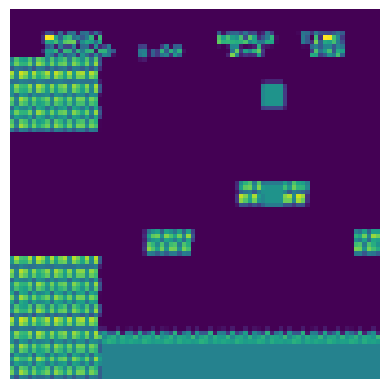

[4000/1500000] Total reward: 46.0 Epsilon: 0.9909895881324888 Size of replay buffer: 36236 Learn step counter: 36205
[4100/1500000] Total reward: 63.0 Epsilon: 0.9894782437225577 Size of replay buffer: 42341 Learn step counter: 42310
[4200/1500000] Total reward: 43.0 Epsilon: 0.9879842708900534 Size of replay buffer: 48385 Learn step counter: 48354
[4300/1500000] Total reward: 62.0 Epsilon: 0.9868613242939975 Size of replay buffer: 52934 Learn step counter: 52903
[4400/1500000] Total reward: 83.0 Epsilon: 0.9854402810554101 Size of replay buffer: 58698 Learn step counter: 58667
[4500/1500000] Total reward: 57.0 Epsilon: 0.9841504453514328 Size of replay buffer: 63937 Learn step counter: 63906
[4600/1500000] Total reward: 76.0 Epsilon: 0.9830505340807864 Size of replay buffer: 68410 Learn step counter: 68379
[4700/1500000] Total reward: 63.0 Epsilon: 0.9818384431949978 Size of replay buffer: 73345 Learn step counter: 73314
[4800/1500000] Total reward: 11.0 Epsilon: 0.9807989813161534 Si

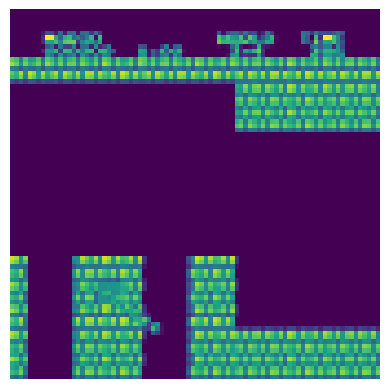

[5000/1500000] Total reward: 107.0 Epsilon: 0.97859123904338 Size of replay buffer: 86596 Learn step counter: 86565
[5100/1500000] Total reward: 3.0 Epsilon: 0.9773257607627238 Size of replay buffer: 91772 Learn step counter: 91741
[5200/1500000] Total reward: 24.0 Epsilon: 0.9762478764828691 Size of replay buffer: 96186 Learn step counter: 96155
[5300/1500000] Total reward: 32.0 Epsilon: 0.9748360234655224 Size of replay buffer: 100000 Learn step counter: 101944
[5400/1500000] Total reward: 34.0 Epsilon: 0.9736978361118153 Size of replay buffer: 100000 Learn step counter: 106617
[5500/1500000] Total reward: 11.0 Epsilon: 0.9725933158634245 Size of replay buffer: 100000 Learn step counter: 111157
[5600/1500000] Total reward: 96.0 Epsilon: 0.9714652758510204 Size of replay buffer: 100000 Learn step counter: 115799


In [ ]:
import os
import re
import torch
import matplotlib.pyplot as plt
import gym_super_mario_bros

from IPython.display import clear_output
from gym_super_mario_bros.actions import RIGHT_ONLY
from nes_py.wrappers import JoypadSpace
from collections import defaultdict

if torch.cuda.is_available():
    print("Using CUDA device:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available")

NUM_EPOCHS = 1_500_000
ENV_NAME = "SuperMarioBrosRandomStages-v0"
CHECKPOINT_SAVE = 1000
CHECKPOINT_PRINT = 100
# In case you're in Google Colab
MODEL_PATH = "/content/drive/MyDrive/ml-models"
if not os.path.exists(MODEL_PATH):
    MODEL_PATH = "./weights_mario"
    os.makedirs(MODEL_PATH, exist_ok=True)
SAMPLE_STAGES=['1-4', '2-4', '3-4', '4-4']
env = gym_super_mario_bros.make(ENV_NAME, stages=SAMPLE_STAGES)
env = JoypadSpace(env, RIGHT_ONLY)
env = apply_wrappers(env)

agent = Agent(input_dims=env.observation_space.shape, 
              num_actions=env.action_space.n)

models_path = sorted(filter(lambda file: file.startswith("nes_mario_model_"), os.listdir(MODEL_PATH)))
if models_path:
  last_model = models_path[-1]
  pattern = "nes_mario_model_(\\d+)_(\\d+)\\.pt"
  start_epoch, total_reward = map(int, re.findall(pattern, last_model)[0])
  agent.load_model(os.path.join(MODEL_PATH, last_model))
  print(f"Loading last model with epoch {start_epoch} and total reward {total_reward}")
  del models_path
else:
  start_epoch = 0

for epoch in range(start_epoch, NUM_EPOCHS):
  done = False
  state = env.reset()
  info = defaultdict(int)
  total_reward = 0
  while not done:
    action = agent.choose_action(state)
    next_state, reward, done, new_info = env.step(action)
    reward = agent.get_custom_reward(reward, info, new_info, done)

    total_reward += reward
    info = new_info

    agent.store_in_memory(state, action, reward, next_state, done)
    agent.learn()

    state = next_state

  if epoch > 0 and epoch % CHECKPOINT_SAVE == 0:
    agent.save_model(os.path.join(MODEL_PATH, f"nes_mario_model_{epoch}_{int(total_reward)}.pt"))
    # -1 because it's a window of states (4 images)
    show(state[-1])

  if epoch > 0 and epoch % CHECKPOINT_PRINT == 0:
    print(f"[{epoch}/{NUM_EPOCHS}] Total reward:", total_reward,
          "Epsilon:", agent.epsilon,
          "Size of replay buffer:", len(agent.replay_buffer),
          "Learn step counter:", agent.learn_step_counter)
env.close()

In [11]:
#agent.save_model(os.path.join(MODEL_PATH, f"nes_mario_model_3293_8.pt"))